In [1]:
import numpy as np
from keras.layers import Dense
import tensorflow as tf
from tensorflow.keras.optimizers  import Adam
from keras import Sequential
import pybullet as p
import time
import pybullet_data
import matplotlib.pyplot as plt
from keras.losses import Huber

In [17]:
class PybulletConnection(object):

    def __init__(self , render):
        
        try : p.disconnect()
            
        except : pass
        
        if render:
            physicsClient = p.connect(p.GUI) 
        else : 
            physicsClient = p.connect(p.DIRECT)
        p.setAdditionalSearchPath(pybullet_data.getDataPath())
        p.createCollisionShape(p.GEOM_PLANE)
        p.createMultiBody(0, 0)
        p.setGravity(0,0,-9.8)
        startPos = [0,0,0]
        startOrientation = p.getQuaternionFromEuler([0,0,0])
        self.bodyObj = p.loadURDF("C://Users/antoz//Self Balancing Robot//balancebot_simple.xml" 
                               , startPos , startOrientation)
        
    def resetEnvironment(BalancingRobot):
        p.resetSimulation()
        p.setAdditionalSearchPath(pybullet_data.getDataPath())
        p.createCollisionShape(p.GEOM_PLANE)
        p.createMultiBody(0, 0)
        p.setGravity(0,0,-9.8)
        startPos = [0,0,0]
        startOrientation = p.getQuaternionFromEuler([0,0,0])
        bodyObj = p.loadURDF("C://Users/antoz//Self Balancing Robot//balancebot_simple.xml" 
                               , startPos , startOrientation) 
        return 0
class BalancingRobot(PybulletConnection):
    
    actions_dect = {0 : [10,-10] , 1:[20, -20] , 2:[30 , -30] , 3: [40,-40] , 4 :[50 , -50 ] ,
               4  : [-10 , 10] , 5:[-20 , 20] , 6:[-30, 30] , 7 : [-40 , 40] , 8 : [-50 , 50] }    
    
    def __init__(self):
        self.reward = 0
        super().__init__(render=False)
        self.motor1 = MotorDC(0 , self.bodyObj)
        self.motor2 = MotorDC(1 , self.bodyObj)
        self.BASE_LINK_INDEX = 0
        
    def controlMotors(self, vel):
        
        self.motor1.currentVelocity = vel[0]
        self.motor2.currentVelocity = vel[1]
        
        p.setJointMotorControlArray(
                bodyIndex = self.bodyObj,
                jointIndices = [self.motor1.motor_index , self.motor2.motor_index],
                controlMode = p.VELOCITY_CONTROL,      
                targetVelocities=vel) 
              
    
    def isTerminalState(self):
        cubePos, _ = p.getBasePositionAndOrientation(self.bodyObj)
        
        return cubePos[2] < 0.15
    
    def read_State(self):
        x_orientation = p.getEulerFromQuaternion(p.getBasePositionAndOrientation(self.bodyObj)[1])[0]
    
        if x_orientation > 0 and x_orientation <= 0.25:
            return 0
    
        if x_orientation >= 0.25 and x_orientation <=0.5:
            return 1
        
        elif x_orientation > 0.5:
            return 2
    
        elif x_orientation < 0 and x_orientation >= -0.25:
            return 3
        
        elif x_orientation < -0.25 and x_orientation >= -0.5:
            return 4
        
        else : return 5
        
    def takeActionFromList(self,velocity):
        self.controlMotors(velocity)
        p.stepSimulation()
            
        if self.isTerminalState():
            self.reward -= 1000
        else :
            self.reward +=0.1
                
    def calculate_reward(self):
        return self.reward
    
    def step(self , action_index):
        
        velocity_list=BalancingRobot.actions_dect[action_index]
        self.takeActionFromList(velocity_list)
        new_state= self.read_State()
        r=self.calculate_reward()
        
        if self.isTerminalState():
            self.reward=0
            self.resetEnvironment()
            
        return (new_state , r)
class MotorDC(object):
    
    def __init__(self , motor_index , bodyObj):
        
        self.motor_index=motor_index
        self.bodyObj= bodyObj
        self.currentVelocity = 0

In [19]:
class ExpMemory(object):
    def __init__(self, memory_size , input_shape ):
        
        self.input_shape = input_shape
        self.memory_size = memory_size
        self.memory = np.zeros((self.memory_size , self.input_shape))
        self.memory_count=0
        
    def store_replay(self , state , actionIndex , reward , new_state  ):
        if self.memory_count < self.memory_size :
            self.memory[self.memory_count] = (state , actionIndex , reward , new_state )
            self.memory_count += 1
        else : 
            raise BufferError("Memory is Full")
        
    def sample_batch(self , batch_size):
        current_memory_size = self.memory_count
        batch_indecies = np.random.choice(self.memory_count , batch_size)
        return self.memory[batch_indecies]
class Qnetwork(object):

    def __init__(self, state_shape , n_actions , lr , fc1 , fc2):
        self.lr = lr
        self.n_actions= n_actions
        self.state_shape=state_shape
        self.model = Sequential([
            Dense(fc1 , activation = 'relu' , input_shape = ( self.state_shape ,)) ,
            Dense(fc2 , activation = 'relu') ,
            Dense(n_actions , activation = 'relu')
        ])
        self.model.compile( optimizer = Adam(learning_rate=lr) , loss='mse' )
    def get_Model(self):
        return self.model
    
class DQNAgent(object):
    def __init__(self, discount_rate , alpha , epsilon , memory_size  
                 , n_actions , input_shape, lr , memory_shape):
        self.discount_rate = discount_rate
        self.alpha = alpha
        self.epsilon = 1
        self.memory_size = memory_size
        self.n_actions= n_actions
        self.input_shape = input_shape
        self.lr=lr
        self.memory_shape = memory_shape
        
        self.replay_memory = ExpMemory(self.memory_size , memory_shape )
        self.q_network = Qnetwork(self.input_shape , self.n_actions 
                                  , self.lr , fc1=20 , fc2=20).get_Model()
        self.batch_size = 32
        self.decay_rate=0.001
        self.train_rewards = []
        
    def epsilon_greedy(self,state):
        if  np.random.rand(1) < self.epsilon:
            action = np.argmax(self.q_network.predict(state))
        else:
            action = np.random.randint(0, self.n_actions)
        return action
    
    def exponential_decay_epsilon(self, state):
        if np.random.rand(1) > self.epsilon:
            action = np.argmax(self.q_network.predict(state))
        else :
            action = np.random.randint(0, self.n_actions)
            
            return action
    def learn(self , myRobot):
        current_state = myRobot.resetEnvironment()
        
        batch_index=np.arange(self.batch_size)
        for i in range(self.batch_size):
            action = self.epsilon_greedy(np.array([current_state]))
            new_state , reward = myRobot.step(action)
            self.replay_memory.store_replay(current_state , action , reward , new_state)
            current_state = new_state
        
        for i in range(50000):
                action = self.epsilon_greedy(np.array([current_state]))
                new_state , reward = myRobot.step(action)
                self.replay_memory.store_replay(current_state , action , reward , new_state)
                batch = self.replay_memory.sample_batch(self.batch_size)
                
                state_batch = batch[: , 0]
                new_state_batch = batch[: , 3]
                actionIndecies_batch = batch[: , 1]
                reward = batch[: , 2]
                
                Qs = self.q_network.predict(state_batch)
                Q_newstate = self.q_network.predict(new_state_batch)
                target=Qs.copy()
                target[batch_index , actionIndecies_batch.astype(np.int32)] = \
                reward + 0.7 * np.max(Q_newstate , axis=1)
                
                self.q_network.fit(state_batch , target , verbose=False)
                
                current_state = new_state
                self.train_rewards.append(reward)

                if i % 100 == 0:
                    print("Average Reward for i = " , np.average(self.train_rewards))
                
        def test(self,  myRobot):
            self.q_network.load("dqn_model.h5")
            state= myRobot.resetEnvironment()
            test_rewards = []
            for i in range(10000):
                action= self.epsilon_greedy(state)
                new_state , reward = myRobot.step(action)
                state=new_state
                total_rewards.append(reward)

                
    def save_model(self):
        self.q_network.save("dqn_model.h5")

    def load_model(self):
        self.q_network = load_model("dqn_model.h5")

In [20]:
myRobot = BalancingRobot()

In [21]:
agent = DQNAgent(discount_rate=0.9 , alpha=0 , epsilon=0.7
                 , memory_size=1000000 , n_actions=9 , input_shape = 1 ,
                 lr = 0.001 , memory_shape=4)
agent.learn(myRobot)

Average Reward for i =  1.4718750000000003
Average Reward for i =  4.235457920792076
Average Reward for i =  5.593516791044767
Average Reward for i =  4.374802740863779
Average Reward for i =  2.808268391521189
Average Reward for i =  0.8713510479041839
Average Reward for i =  -0.14937084026623038
Average Reward for i =  -0.9787089871612054
Average Reward for i =  -1.988666510611742
Average Reward for i =  -2.748876248612659
Average Reward for i =  -3.1001810689310747
Average Reward for i =  -3.642909854677572
Average Reward for i =  -4.265383014154876
Average Reward for i =  -4.599870292083018
Average Reward for i =  -5.229262580299791
Average Reward for i =  -5.905082028647573
Average Reward for i =  -6.330639053716433
Average Reward for i =  -6.640625000000005
Average Reward for i =  -6.8812326485285995
Average Reward for i =  -7.020592780115733
Average Reward for i =  -7.132949150424792
Average Reward for i =  -7.328514695383156
Average Reward for i =  -7.646495910949572
Average Re

Average Reward for i =  -4.647970830482649
Average Reward for i =  -4.53254999738238
Average Reward for i =  -4.421136106192431
Average Reward for i =  -4.319172743640271
Average Reward for i =  -4.216651203546256
Average Reward for i =  -4.115560099482127
Average Reward for i =  -4.001788333503442
Average Reward for i =  -3.9064671526826555
Average Reward for i =  -3.8131811524670987
Average Reward for i =  -3.726709556052512
Average Reward for i =  -3.643533135843261
Average Reward for i =  -3.563471655639077
Average Reward for i =  -3.49540028958968
Average Reward for i =  -3.410242414166846
Average Reward for i =  -3.3376049274545943
Average Reward for i =  -3.263975232915526
Average Reward for i =  -3.177996365467755
Average Reward for i =  -3.091843993043874
Average Reward for i =  -3.014016153069625
Average Reward for i =  -2.9271344672504327
Average Reward for i =  -2.849135606637842
Average Reward for i =  -2.7523260153547864
Average Reward for i =  -2.6628910487713493
Average

Average Reward for i =  16.11675103400442
Average Reward for i =  16.37569262225539
Average Reward for i =  16.63306440587496
Average Reward for i =  16.885120922183976
Average Reward for i =  17.137860094298233
Average Reward for i =  17.402088851063457
Average Reward for i =  17.685786529342227
Average Reward for i =  17.93741444628695
Average Reward for i =  18.21221330863336
Average Reward for i =  18.470190180558312
Average Reward for i =  18.7435801223186
Average Reward for i =  19.03402911185498
Average Reward for i =  19.304358391919333
Average Reward for i =  19.599218295106827
Average Reward for i =  19.88929122686336
Average Reward for i =  20.197634820282037
Average Reward for i =  20.486175048994205
Average Reward for i =  20.786540515902345
Average Reward for i =  21.093067048324315
Average Reward for i =  21.422706650084095
Average Reward for i =  21.723469798637435
Average Reward for i =  22.062248300290936
Average Reward for i =  22.376068661667446
Average Reward for i

KeyboardInterrupt: 

In [23]:
agent.q_network.save("dqn_model.h5")

In [70]:
k = np.ones(100)/100
smoothed = np.convolve(np.array(agent.train_rewards).flatten(), k, 'valid')

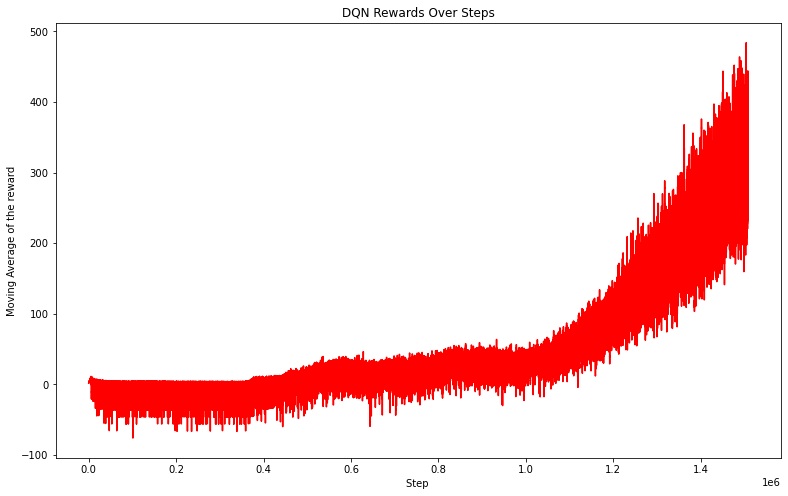

In [71]:
plt.figure(figsize=(13,8))
plt.title("DQN Rewards Over Steps")
plt.xlabel("Step ")
plt.ylabel("Moving Average of the reward")
plt.plot(np.arange(len(smoothed)) , smoothed , color='r' , linestyle=None)